코드 생성

In [367]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.signal import correlate
from mpl_toolkits.mplot3d import Axes3D
from collections import deque  
import random as rand

sats = [(1, 5), (2, 6), (3, 7), (4, 8), (0, 8), (1, 9), (0, 7), (1, 8), (2, 9), (1, 2),
            (2, 3), (4, 5), (5, 6), (6, 7), (7, 8), (8, 9), (0, 3), (1, 4), (2, 5), (3, 6),
            (4, 7), (5, 8), (0, 2), (3, 5), (4, 6), (5, 7), (6, 8), (7, 9), (0, 5), (1, 6),
            (2, 7), (3, 8), (4, 9), (3, 9), (0, 6), (1, 7), (3, 9)]
g1tap = [2,9]
g2tap = [1,2,5,7,8,9]
# -5000, -4500, -4000, -3500, -3000, -2500, -2000, -1500, -1000, -500, 0, 500, 1000, 1500, 2000, 2500, 3000, 3500, 4000, 4500, 5000
def getCode(satsNum):
    
    g1 = deque(1 for i in range(10))
    g2 = deque(1 for i in range(10))
     
    # result
    g = []
    
    # Generating 1023 chips(One C/A sequence)
    for i in range(1023):
        val = (g1[9] + g2[satsNum[0]] + g2[satsNum[1]]) % 2
        g.append(val)
        
        #shift g1
        g1[9] = sum(g1[i] for i in g1tap) % 2
        g1.rotate()
        
        #shift g2
        g2[9] = sum(g2[i] for i in g2tap) % 2
        g2.rotate()
    # 0 => -1
    for n,i in enumerate(g):
            if i==0:
                g[n]=-1
        
    return g

# 코드 미리 만들어두기(시간복잡도 줄이려고)
codes = []
for i in range(37):
    codes.append(getCode(sats[i]))

In [368]:
OV = 10
ms = 100 # message 한 bit 마다 20ms #원래는 2초 봐야해서 2000



# C/A code Frequency : 1.023MHz
# IF Frequency : 9.548MHz
# Sampling rate : 38.192MHz
# OV should be 4.
# 알아낸 곳: Kai Borre의 A Software-Defined GPS and Galileo Receiver에서의 p.55(pdf 상으로는 70페이지)
# 이것들 적용해야 하는데, 아직 할 줄 모른다...

Noise 생성

In [369]:
# 잡음의 전력 비 설정 (잡음은 전력 1, 신호전력은 1/6.31 이런 식으로 만들기)
noise_power = 6.31 # For -8dB. If -22dB, set noise_power to 158.49
#noise_power = 0.000001

# 잡음의 크기 설정
num_samples = 1023 * ms * OV

# 실수부와 허수부에 대한 잡음 생성
real_noise = np.random.normal(0, 1, num_samples) / (np.sqrt(2) * np.sqrt(OV))
imaginary_noise = np.random.normal(0, 1, num_samples) / (np.sqrt(2) * np.sqrt(OV))

# 복소수로 변환
complex_noise = (real_noise + 1j * imaginary_noise) 

# 신호가 쓸 거
sigma = np.sqrt(noise_power)

Data 생성

In [370]:
data = []
for i in range(ms//20):
    data.append((-1)**i)
RN = rand.randint(0,36)
t_code = codes[RN]
t_code = [chip/(sigma*np.sqrt(OV)) for chip in t_code for _ in range(OV)]
t_code_inv = [x*-1 for x in t_code]
seq = []

# data = [1,1,-1,-1,-1]

for d in data:
    if d == 1:
        seq.extend(t_code*20)
    else:
        seq.extend(t_code_inv*20)
        

cor_data = []
for value in data:
    cor_data.extend([value] * 20)


Signal 생성

In [371]:
def generate_transmitted_signal(code_delay, doppler_freq, svNumber, code_freq, signal_length, OV = 1.023e6*OV):
    # delayed_seq = np.roll(seq, code_delay) # code_delay : delay된 sample 수
    t = np.arange(signal_length)
    code_phase = 2 * np.pi * code_freq * t / OV
    ct = np.cos(code_phase) * seq
    oversampled_signal = np.cos(code_phase) * np.exp(1j * (2 * np.pi * doppler_freq * t / OV))
    # oversampled_signal = np.exp(1j*(2*np.pi * (code_freq + doppler_freq) * t / OV))
    signal = ct * oversampled_signal[:signal_length] + complex_noise
    delayed_signal = np.roll(signal, code_delay)
    return delayed_signal
    

Replica 신호 생성

In [372]:
def generate_replica_signal(code_delay, doppler_freq, code_freq, svNumber, signal_length = 1023*OV ,OV = 1.023e6*OV ):
    ca_code = np.array(codes[svNumber])
    ca_code = [chip for chip in ca_code for _ in range(int(OV//1.023e6))]
    # delayed_code = np.roll(ca_code, code_delay)
    
    t = np.arange(signal_length)
    code_phase = 2 * np.pi * code_freq * t / OV
    ct = np.cos(code_phase) * ca_code
    oversampled_signal = np.cos(code_phase) * np.exp(1j * (2 * np.pi * (doppler_freq) * t / OV))
    # oversampled_signal = np.exp(1j*(2*np.pi * (code_freq + doppler_freq) * t / OV))
    replica =  ct * oversampled_signal[:signal_length]
    delayed_replica = np.roll(replica, code_delay)
    return delayed_replica
    

Acquisition

In [373]:
def acquisition(signal, code_delay_range, doppler_freq_range,code_freq, svNumber, signal_length, OV):
    
    # 신호 1ms씩 쪼개기
    signal_div = [signal[i:i+(1023*OV)] for i in range(0,len(signal), 1023*OV)]
    
    # 1ms 안에서 F(code 혹은 frame delay & 주파수 offset 찾기)
    max_corr = 0
    max_code_delay = 0
    max_doppler_freq = 0
    corr_matrix = np.zeros((len(code_delay_range), len(doppler_freq_range)))
    
    Fsignal = signal_div[0] 
    for i, doppler_freq in enumerate(doppler_freq_range):
        replica = generate_replica_signal(code_delay_range[0],doppler_freq,code_freq, svNumber)
        
        for j, code_delay in enumerate(code_delay_range):
            
            cor = np.abs(correlate(Fsignal, replica, mode='valid'))
            peak = np.max(cor)
            corr_matrix[j, i] = peak
            
            if peak > max_corr:
                max_corr = peak
                max_code_delay = code_delay
                max_doppler_freq = doppler_freq
            replica = np.roll(replica, (OV if OV == 1 else OV//2)) # sampling 안 했을 경우 1씩, 했으면 0.5 chip씩 이동
            
    print('-'*40)
    print('Frame Sync completed.')
    print('Frame delay :', max_code_delay/OV)
    print('Estimated_Frequency Offset :', max_doppler_freq)
    print('Max correlation :', max_corr)
    print('-'*40)
    
    
    # 20ms 안에서 bit boundary(B) 값 탐색
    True_replica = generate_replica_signal(max_code_delay, max_doppler_freq, code_freq, svNumber)
    cor_lst = []
    phase  = []
    for i in range(ms):
        cor = correlate(signal_div[i], True_replica, mode = 'valid')
        cor_lst.append(np.max(cor)) #cor_lst 얘로 phase 계산
        phase.append(np.arctan2(np.imag(cor), np.real(cor))) #왜 arctan2를 썼을까
    print(*phase)
    phase_diff = []
    for i in range(1, ms):
        """if phase[i-1] <= -(np.pi)/2 and phase[i] >= (np.pi)/2:
            phase_diff.append(2*np.pi + (phase[i]- phase[i-1]))
        elif phase[i-1] >= np.pi/2 and phase[i] <= -np.pi/2:
            phase_diff.append(2*np.pi - (phase[i]- phase[i-1]))
        else:
            phase_diff.append(phase[i]-phase[i-1])"""
        if np.real(phase[i])<0 and np.imag(phase[i])>0 and np.real(phase[i-1])<0 and np.imag(phase[i-1])<0:
            phase_diff.append((2*np.pi-(phase[i]-phase[i-1]))) #360도 - 차이
        else:
            phase_diff.append(((phase[i]-phase[i-1]))) 
    print(*phase_diff)  
    mean_phasediff = sum(phase_diff)/ms
    
    
    return max_code_delay, max_doppler_freq, cor_lst, phase, phase_diff, corr_matrix
    
    
    
    
            

Acquisition 실행

In [374]:
#bit boundary 찾아야 한다
#노이즈 좀더 크게


# Parameters
####### B = rand.randint(0,20)  # Bit Boundary 무작위 설정 - bit boundary - 1ms안에서 맞추는거 (frame 동기화도 있음)
F = rand.randint(0,1023) # 1ms code 내 delay 설정


code_delay_range = np.arange(0, 1023*OV, (OV if OV == 1 else OV//2))    # 단순히 F를 찾기 위한 범위 #늘려놓음-그래야 bit  boundary 찾는 의미 생기니까
doppler_freq_range = np.linspace(-5000, 5000, 21)  # Adjusted range of Doppler frequency in Hz
code_freq = 1.023e6  # Code frequency in Hz
svNumber = RN

# Generate received signal
true_code_delay = rand.randint(0, (19*1023+F)*OV) # Range of code delay in chips (0 ~ 1023*19 + F)


true_doppler_freq = rand.randint(-5000,5000)
# true_doppler_freq = rand.sample(range(-5000, 5000, 500), 1)[0]
#true_doppler_freq = 10


received_signal = generate_transmitted_signal(true_code_delay, true_doppler_freq, svNumber, code_freq, 1023*20*(ms//20)*OV)

# Perform acquisition
estimated_code_delay, estimated_doppler_freq, cor_lst, phase, phase_diff, corr_matrix = acquisition(received_signal, code_delay_range, doppler_freq_range, code_freq, svNumber,1023*20*(ms//20)*OV,OV)

print()
print("-"*18,'Test','-'*18)
print("Target SV Number:", svNumber + 1)
print("True Code Delay:", true_code_delay/OV) #frame delay?
print("True doppler frequency:", true_doppler_freq)
print('-'*40)
print("B :", true_code_delay//(OV*1023))
B = true_code_delay//(OV*1023)


----------------------------------------
Frame Sync completed.
Frame delay : 77.0
Estimated_Frequency Offset : 1000.0
Max correlation : 289.11300367190506
----------------------------------------
[1.10231384] [1.5459179] [2.08106404] [2.58974876] [3.06593036] [-2.83113469] [0.270058] [0.64895673] [1.17335084] [1.68971662] [1.97554913] [2.6997378] [3.03047728] [-2.67930116] [-2.18265595] [-1.78423747] [-1.28645821] [-0.87467163] [-0.34482857] [0.10517869] [0.56187508] [1.09742734] [1.59651226] [2.12687445] [2.61139234] [3.01700979] [0.39474079] [0.76558789] [1.25775661] [1.76731232] [2.31457483] [2.72174115] [-3.14127845] [-2.61130479] [-2.12306511] [-1.79596131] [-1.16389532] [-0.6693197] [-0.184358] [0.19659573] [0.7756876] [1.16867054] [1.68302768] [2.14525439] [2.66173852] [3.11428224] [0.40234146] [0.87199417] [1.41288835] [1.87185403] [2.35458945] [2.878508] [-2.95673142] [-2.48798204] [-1.96394717] [-1.56618523] [-1.0158096] [-0.59129763] [-0.13915251] [0.37139588] [0.8988801] [1

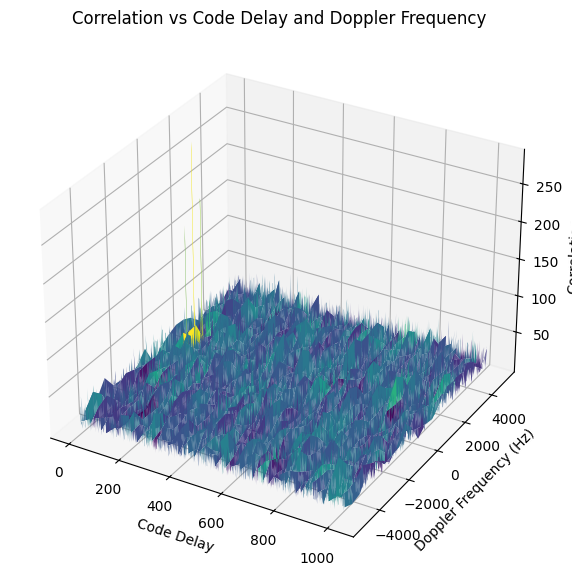

In [375]:
# Plotting
Code_Delay, Doppler_Freq = np.meshgrid(code_delay_range//OV, doppler_freq_range)
fig = plt.figure(figsize=(10, 7))
ax = fig.add_subplot(111, projection='3d')
ax.plot_surface(Code_Delay, Doppler_Freq, corr_matrix.T, cmap='viridis')
ax.set_xlabel('Code Delay')
ax.set_ylabel('Doppler Frequency (Hz)')
ax.set_zlabel('Correlation')
ax.set_title('Correlation vs Code Delay and Doppler Frequency')
plt.show()



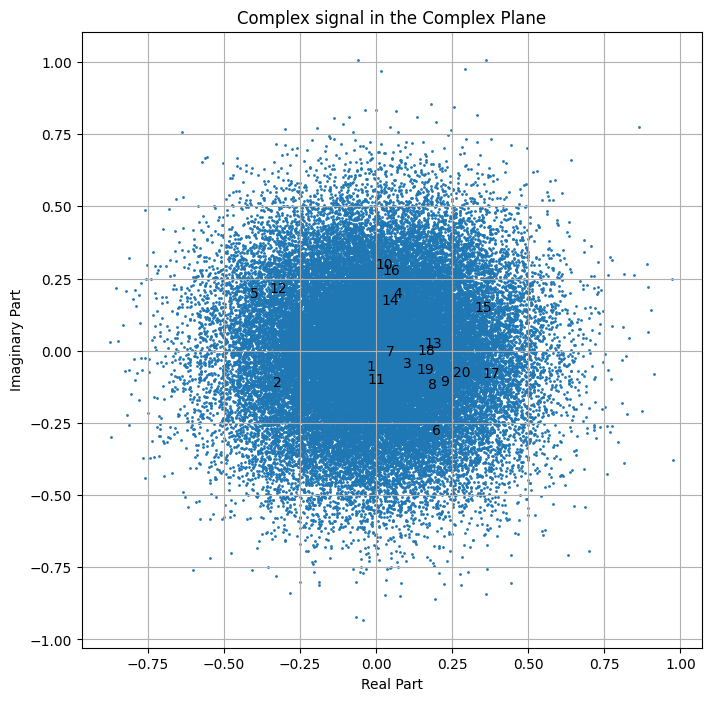

In [376]:
plt.figure(figsize=(8, 8))
#plt.scatter(np.real(received_signal[:1023*20]), np.imag(received_signal[:1023*20]), s=1)
plt.scatter(np.real(received_signal[::20]), np.imag(received_signal[::20]), s=1)

for i, txt in enumerate(range(1, 0 + 21)):
    plt.annotate(f'{txt}', (np.real(received_signal[i]), np.imag(received_signal[i])))
    
plt.title("Complex signal in the Complex Plane")
plt.xlabel("Real Part")
plt.ylabel("Imaginary Part")
plt.grid(True)
plt.show()

In [377]:
# cor_lst = [cor_lst[i] * cor_data[i] for i in range(100)]



Index 0: 25.416640576246337
Index 1: 30.661615111835896
Index 2: 29.145487181159318
Index 3: 27.283196307092375
Index 4: -337.8769390024048
Index 5: 177.6852526032135
Index 6: 21.709298086505154
Index 7: 30.045569274137765
Index 8: 29.585580172283823
Index 9: 16.376996038467933
Index 10: 41.492954403028264
Index 11: 18.949976289302896
Index 12: -327.1462064298813
Index 13: 28.455674619710575
Index 14: 22.827697421957975
Index 15: 28.52065065601174
Index 16: 23.593633012251132
Index 17: 30.357771056143797
Index 18: 25.783516861718827
Index 19: 26.16677569100894
Index 20: 30.684884341665114
Index 21: 28.59545916362455
Index 22: 30.387515285637832
Index 23: 27.760830400683787
Index 24: 23.24016763458941
Index 25: -150.2449464134089
Index 26: 21.247973625546543
Index 27: 28.199190666831665
Index 28: 29.19539157373116
Index 29: 31.355831939286674
Index 30: 23.328911762359002
Index 31: -335.9262784514669
Index 32: 30.36525416989234
Index 33: 27.974072973566273
Index 34: 18.741667151870207
I

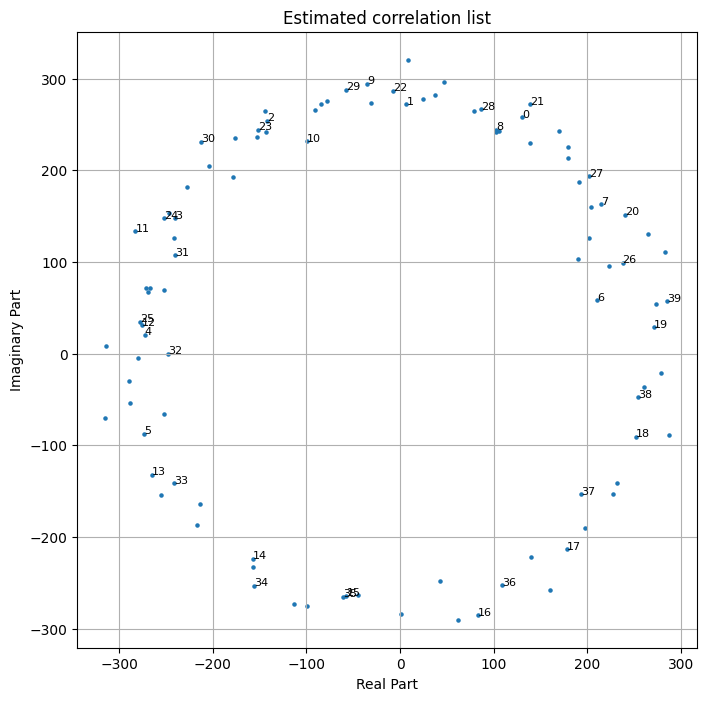

In [378]:
print()
degree_list = [np.degrees(value) for sublist in phase_diff for value in sublist]
for idx, value in enumerate(degree_list):
    print(f"Index {idx}: {value}")

plt.figure(figsize=(8, 8))
plt.scatter(np.real(cor_lst), np.imag(cor_lst), s=5)

for i, txt in enumerate(range(0, 0 + 40)):
    plt.annotate(f'{txt}', (np.real(cor_lst[i]), np.imag(cor_lst[i])), fontsize = 8)
    
plt.title("Estimated correlation list")
plt.xlabel("Real Part")
plt.ylabel("Imaginary Part")
plt.grid(True)
plt.show()

# 주파수 offset = 0일 때 1~20번은 오른쪽, 21~39번이 왼쪽에 있다면 bit boundary 잘 찾은거.(부호반전)
# 위아래로 돌아간 거는 noise에 의한 영향 + 약간의 주파수 offset과 code delay에 관한 거.

In [379]:

print(degree_list)
for i in range(len(degree_list)):
    if degree_list[i]<0:
        degree_list[i] = 360+degree_list[i]



#나중에 20개씩 슬라이딩하면서 튀는값을 찾아야함 - 찾으면 그거의 인덱스 반환

# 차이가 다른 값들과 많이 나는 값을 찾는 함수
def find_outlier(cor_lst):
    # 교차 상관 값들 사이의 차이를 저장할 변수 초기화
    max_difference = 0
    outlier_value = None
    outlier_index = None
    
    # 각 값들 사이의 차이를 계산하여 가장 큰 차이를 갖는 값을 찾음
    for i in range(len(cor_lst) - 1):
        difference = abs(cor_lst[i] - cor_lst[i + 1])
        if difference > max_difference:
            max_difference = difference
            outlier_value = cor_lst[i] if cor_lst[i] > cor_lst[i + 1] else cor_lst[i + 1]
            outlier_index = i if cor_lst[i] > cor_lst[i + 1] else i + 1
    
    return outlier_value, outlier_index

# 차이가 다른 값들과 많이 나는 값을 찾음
outlier_value, outlier_index = find_outlier(degree_list[:40])
print("Outlier Value:", outlier_value)
print("Outlier Index:", outlier_index)


print(B)
print(cor_lst)

[25.416640576246337, 30.661615111835896, 29.145487181159318, 27.283196307092375, -337.8769390024048, 177.6852526032135, 21.709298086505154, 30.045569274137765, 29.585580172283823, 16.376996038467933, 41.492954403028264, 18.949976289302896, -327.1462064298813, 28.455674619710575, 22.827697421957975, 28.52065065601174, 23.593633012251132, 30.357771056143797, 25.783516861718827, 26.16677569100894, 30.684884341665114, 28.59545916362455, 30.387515285637832, 27.760830400683787, 23.24016763458941, -150.2449464134089, 21.247973625546543, 28.199190666831665, 29.19539157373116, 31.355831939286674, 23.328911762359002, -335.9262784514669, 30.36525416989234, 27.974072973566273, 18.741667151870207, 36.21471390047141, 28.337095403183252, 27.786258966805867, 21.827040969453932, 33.179519786911804, 22.51626374184434, 29.470493603173367, 26.483639794088393, 29.592360742350962, 25.928845021132854, -155.3827611940266, 26.90911822606455, 30.9909538114981, 26.296796239016402, 27.658702361200255, 30.01832188

In [380]:
import cmath


cor_lst_1 = cor_lst[:20]
cor_lst_2 = cor_lst[20:40] 
cor_lst_3 = cor_lst[40:60]
cor_lst_4 = cor_lst[60:80]
cor_lst_5 = cor_lst[80:100]




new_s_1 = [0] * (len(cor_lst_1) - 1)  # cor_lst의 길이보다 하나 작은 크기의 빈 리스트 생성

cumulative_phase = 0
for i in range(len(cor_lst_1)-1):
    cumulative_phase += phase_diff[i]
    new_s_1[i] = cor_lst_1[i] * cmath.exp(-1j * cumulative_phase)

print(new_s_1)


new_s_2 = [0] * (len(cor_lst_2) - 1)  # cor_lst의 길이보다 하나 작은 크기의 빈 리스트 생성

#cumulative_phase = 0
#cumulative_phase += np.pi
for i in range(len(cor_lst_2)-1):
    cumulative_phase += phase_diff[i+19]
    new_s_2[i] = cor_lst_2[i] * cmath.exp(-1j * cumulative_phase)

print(new_s_2)


new_s_3 = [0] * (len(cor_lst_3) - 1)  # cor_lst의 길이보다 하나 작은 크기의 빈 리스트 생성

#cumulative_phase = 0
#cumulative_phase += np.pi
for i in range(len(cor_lst_3)-1):
    cumulative_phase += phase_diff[i+39]
    new_s_3[i] = cor_lst_3[i] * cmath.exp(-1j * cumulative_phase)

print(new_s_3)


new_s_4 = [0] * (len(cor_lst_4) - 1)  # cor_lst의 길이보다 하나 작은 크기의 빈 리스트 생성

#cumulative_phase = 0
#cumulative_phase += np.pi
for i in range(len(cor_lst_4)-1):
    cumulative_phase += phase_diff[i+59]
    new_s_4[i] = cor_lst_4[i] * cmath.exp(-1j * cumulative_phase)

print(new_s_4)



new_s_5 = [0] * (len(cor_lst_5) - 1)  # cor_lst의 길이보다 하나 작은 크기의 빈 리스트 생성

#cumulative_phase = 0
#cumulative_phase += np.pi
for i in range(len(cor_lst_5)-1):
    cumulative_phase += phase_diff[i+79]
    new_s_5[i] = cor_lst_5[i] * cmath.exp(-1j * cumulative_phase)

print(new_s_5)

[(228.62554138306848+176.9652246049767j), (229.30185713741602+146.06066580707682j), (241.23398121184692+162.79061424708513j), (228.68636907835338+165.38768790294998j), (206.12247943081496+179.39989273365535j), (-119.07892985646123-260.9650165146744j), (163.4659076701487+144.36136203274668j), (225.5531159806301+147.10557936373561j), (220.70371820098262+146.4817294169086j), (203.08376300698598+216.11808594069774j), (234.51831641797958+93.16015555321245j), (224.12412349478112+218.0117360652731j), (239.34987571683564+139.88796045416058j), (243.32322635000463+168.49916594132995j), (208.47202666218487+176.98634191786078j), (222.47773742586256+153.69085454582648j), (229.5249152159096+189.63874469460154j), (233.69017420428395+150.6039626582342j), (212.8792167174944+162.6078697393844j)]
[(128.32012865596397+253.56788303052116j), (137.8586515045566+272.41654747069265j), (129.60316830279885+256.1032424515236j), (129.8852446152402+256.66064131129724j), (131.70446213381592+260.2555187462635j), (126

C:\Users\Admin\AppData\Local\Temp\ipykernel_19700\250185475.py:18: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  new_s_1[i] = cor_lst_1[i] * cmath.exp(-1j * cumulative_phase)
C:\Users\Admin\AppData\Local\Temp\ipykernel_19700\250185475.py:29: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  new_s_2[i] = cor_lst_2[i] * cmath.exp(-1j * cumulative_phase)
C:\Users\Admin\AppData\Local\Temp\ipykernel_19700\250185475.py:40: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  new_s_

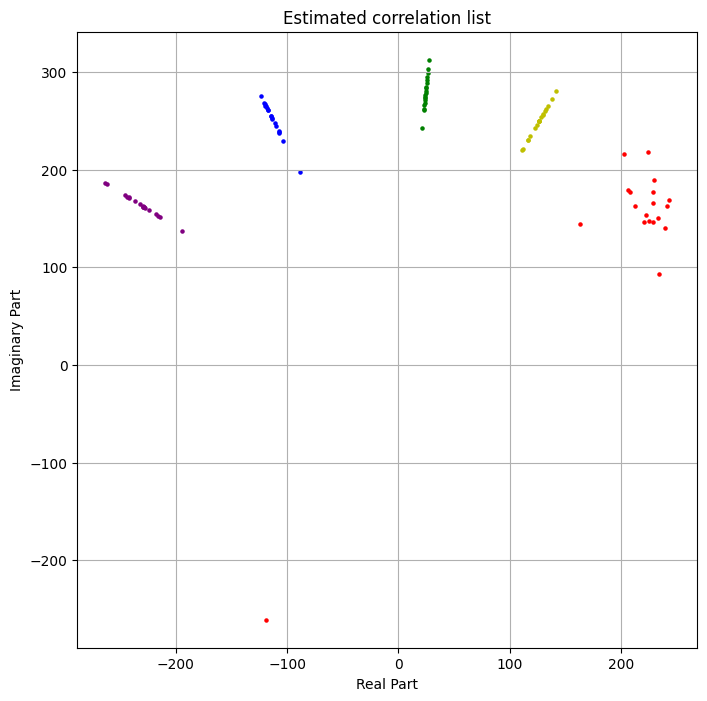

In [381]:
plt.figure(figsize=(8, 8))
plt.scatter(np.real(new_s_1), np.imag(new_s_1), s=5, label='New_s_1', c='r')
plt.scatter(np.real(new_s_2), np.imag(new_s_2), s=5, label='New_s_2', c='y')
plt.scatter(np.real(new_s_3), np.imag(new_s_3), s=5, label='New_s_3', c='g')
plt.scatter(np.real(new_s_4), np.imag(new_s_4), s=5, label='New_s_4', c='b')
plt.scatter(np.real(new_s_5), np.imag(new_s_5), s=5, label='New_s_5', c='purple')
    
plt.title("Estimated correlation list")
plt.xlabel("Real Part")
plt.ylabel("Imaginary Part")
plt.grid(True)
plt.show()


## 밑에는

## 작업중

## 병렬구조 만들기 (Demod, DLL 하기 전)

신호를 I, Q로 쪼갠 뒤 각각을 계산해야함

In [382]:
# Extract real and imaginary parts separately
def spliter(signal):
    return np.real(signal), np.imag(signal)

real_part, imaginary_part = spliter(received_signal)

cur_code_delay = estimated_code_delay

E = generate_replica_signal(cur_code_delay - (OV // 2), estimated_doppler_freq, code_freq, svNumber)
P = generate_replica_signal(cur_code_delay, estimated_doppler_freq, code_freq, svNumber)
L = generate_replica_signal(cur_code_delay + (OV // 2), estimated_doppler_freq, code_freq, svNumber)

Real_E, Imag_E = spliter(E)
Real_P, Imag_P = spliter(P)
Real_L, Imag_L = spliter(L)

signal_div_Real = [real_part[i:i+(1023*OV)] for i in range(0,len(real_part), 1023*OV)]
signal_div_Imaginary = [imaginary_part[i:i+(1023*OV)] for i in range(0,len(imaginary_part), 1023*OV)]

def I_and_D(signal, replica):
    correlation = []
    for lst in signal:
        cor = correlate(lst, replica,mode='valid')
        correlation.append(np.max(cor))
    return list(correlation)

I_E = I_and_D(signal_div_Real, Real_E)
Q_E = I_and_D(signal_div_Imaginary, Imag_E)
I_P = I_and_D(signal_div_Real, Real_P)
Q_P = I_and_D(signal_div_Imaginary, Imag_P)
I_L = I_and_D(signal_div_Real, Real_L)
Q_L = I_and_D(signal_div_Imaginary, Imag_L)


print(I_E)
print(Q_E)
print(I_P)
print(Q_P)
print(I_L)
print(Q_L)

[66.75442847556353, 6.047901280631423, -56.466394349604776, -91.59887387878638, -124.2739911019376, -129.45603240178608, 100.02761158563307, 121.99193241216574, 51.25193349221741, 0.6097046139944862, -49.21758162703913, -122.31223873081994, -145.3139214863078, -121.74878601187606, -70.24740522786794, -39.39719002098333, 34.80531983494924, 77.91541498395277, 104.55524892788102, 138.61617015675085, 114.93632674978721, 79.25240498557915, 6.471371290255925, -51.397325281233975, -108.20092699354976, -146.39439578945138, 95.43007726230428, 96.42235244244937, 50.224329150222445, -26.83055888544682, -88.55001833787148, -121.57892425625552, -131.45536334129966, -118.70073126001174, -76.94418743236908, 0.24867509270754695, 42.6744689055082, 82.61247309095889, 128.41436243543987, 130.1544608209396, 92.97642500322927, 46.54362193949299, -5.110689837057501, -72.99281666841067, -104.04823086497721, -149.76156105521, 82.82800815819922, 93.29601881761808, 27.67179580594847, -24.763676283047975, -94.04

In [383]:
#incoming signal 받고
#NCO carrier generator에서 받아와서 sin, cos 곱해
#여기까지  signal * sin, signal * cos


#그거랑 PRN이랑 곱해(E,P,L)
#여기까지 signal*sin*PRN...


# Residual code/carrier phase
remCodePhase = 0.0

# define residual carrier phase
remCarrPhase  = 0.0

# code tracking loop parameters
oldCodeNco   = 0.0
oldCodeError = 0.0

# carrier/Costas loop parameters
oldCarrNco = 0.0
oldCarrError = 0.0

dataPosition = 0
blksize = 0


carrFreq = -3363.8
fs = 1023*OV*1000
codeLength = 1023
earlyLateSpacing = 0.5
chippingRate = 1023000
codeFreq = 1023000







In [384]:
# 91p
# Calculate filter coefficient values for code loop
def calculate_loop_coefficients(loop_noise_bandwidth, zeta, loop_gain, sum_int):
    """
    Calculates the loop coefficients tau1 and tau2.

    This process is discussed in sections 7.1-7.3 of Borre.

    Parameters:
    loop_noise_bandwidth (float): Loop noise bandwidth.
    zeta (float): Damping ratio.
    loop_gain (float): Loop gain.
    sum_int (float): Summation interval.

    Returns:
    tuple: Coefficient 1 (coeff1) and Coefficient 2 (coeff2).
    """
    # Solve for the natural frequency
    wn = loop_noise_bandwidth * 8 * zeta / (4 * zeta**2 + 1)

    # Solve for tau1 and tau2
    tau1 = loop_gain / (wn * wn)
    tau2 = (2.0 * zeta) / wn

    coeff1 = tau2 / tau1
    coeff2 = float(sum_int) / tau1

    return coeff1, coeff2


#91p참고 (loop_gain, sum_int는 모르겠다)
loop_noise_bandwidth = 20
zeta = 0.7
loop_gain = 1
sum_int = 1e-3
#coeffCode1, coeffCode2 = calculate_loop_coefficients(loop_noise_bandwidth,zeta,loop_gain,sum_int)
#coeffCar1, coeffCar2 = calculate_loop_coefficients(loop_noise_bandwidth,zeta,loop_gain,sum_int)
coeffCode1, coeffCode2 = 5.2972972972972965, 0.014317019722425127
coeffCar1, coeffCar2 = 264.86486486486484, 8.948137326515706

print(coeffCode1, coeffCode2)
print(coeffCar1, coeffCar2)

t_code = [item for item in t_code for _ in range(10)]

5.2972972972972965 0.014317019722425127
264.86486486486484 8.948137326515706


In [385]:

#Store the shift registers as a deque, so that deque.rotate() can be used.
from collections import deque  
import numpy as np

'''
GPS Gold Code generator. Initialized with the feedback taps for one satellite.
'''

#Feedback taps as defined in GPS spec
g1tap = [2,9]
g2tap = [1,2,5,7,8,9]

sats = [(1, 5), (2, 6), (3, 7), (4, 8), (0, 8), (1, 9), (0, 7), (1, 8), (2, 9), (1, 2),
            (2, 3), (4, 5), (5, 6), (6, 7), (7, 8), (8, 9), (0, 3), (1, 4), (2, 5), (3, 6),
            (4, 7), (5, 8), (0, 2), (3, 5), (4, 6), (5, 7), (6, 8), (7, 9), (0, 5), (1, 6),
            (2, 7), (3, 8), (4, 9), (3, 9), (0, 6), (1, 7), (3, 9)]


def getCode(num, zero = False, samplesPerChip = 1, prn = 0):
    '''
    Returns a list of bits that form the Gold Code PRN of the designated satellite
    
    zero flag determines whether 0 or -1 is returned
    '''
    g1 = deque(1 for i in range(10))
    g2 = deque(1 for i in range(10))
    
        
    g = []

    for i in range(num):
        val = (g1[9] + g2[prn[0]] + g2[prn[1]]) % 2
        g.append(val)

        #Shift g1
        g1[9] = sum([g1[i] for i in g1tap]) % 2 
        g1.rotate()

        #Shift g2
        g2[9] = sum([g2[i] for i in g2tap]) % 2 
        g2.rotate()

    if(zero == False):
        #format GC to have -1 in place of 0
        for n,i in enumerate(g):
            if i==0:
                g[n]=-1
    
    if (samplesPerChip > 1 ):
        # Repeat each chip to match our ADC sample frequency
        gsamp = np.repeat(g, samplesPerChip)
        return gsamp
    return g

def getTrackingCode(sat):
    '''
    Returns a code ready to be used by Tracking.py
    '''
    code = np.array(getCode(1023, prn = sats[sat - 1]))

    # Need to add extra code chips to the ends so that it can 'slide'
    # back and forth during tracking.
    code = np.append(code,code[0])
    code = np.insert(code,0, code[len(code) - 2])
    return code


def getAcquisitionCode(sat, spc):
    '''
    Returns a code ready to be used by Acquisition.py
    '''
    return getCode(1023, samplesPerChip = spc, prn = sats[sat-1])



## Tracking loop test

In [386]:

import numpy as np
import matplotlib.pyplot as plt
import configparser



# code tracking loop parameters
oldCodeNco   = 0.0
oldCodeError = 0.0

# carrier/Costas loop parameters
oldCarrNco   = 0.0
oldCarrError = 0.0

acquiredCarrFreq = estimated_doppler_freq
chippingRate = code_freq #codeFreqBasis

dataPosition = 0
CACode = getTrackingCode(RN)

I_P_list = []

# Process the requested number of code periods (num of ms to process)
for i in range(0, ms):
    print("\n------- %2.1f percent complete --------"%((i/ms)*100), end = '\r')
    # Find PLL error and update carrier NCO
    # Implement carrier loop discriminator (phase detector)

    # Update the phasestep based on code freq (variable) and
    # sampling frequency (fixed)
    codePhaseStep = np.real(codeFreq / fs) #맨아래에서 업데이트 시킨 codeFreq여기서 사용-LOOP
    
    
    #print("Old blksize: %d"%blksize)
    blksize = int(np.ceil((codeLength-remCodePhase) / codePhaseStep))
    #print("New blksize: %d"%blksize)
    #print("Old remCodePhase: %f" %remCodePhase)

    # Read in the appropriate number of samples to process this
    # iteration
    rawSignal = received_signal[dataPosition:dataPosition+blksize]
    dataPosition = dataPosition + blksize


    
    # Generate Early CA Code.
    tStart = remCodePhase - earlyLateSpacing
    tStep = codePhaseStep
    tEnd = ((blksize-1)*codePhaseStep+remCodePhase) + codePhaseStep - earlyLateSpacing
    tcode = np.linspace(tStart,tEnd,blksize,endpoint=False)
    tcode2 = (np.ceil(tcode)).astype(int)
    earlyCode = CACode[tcode2]




    # Generate Late CA Code.
    tStart = remCodePhase + earlyLateSpacing
    tStep = codePhaseStep
    tEnd = ((blksize-1)*codePhaseStep+remCodePhase) + codePhaseStep + earlyLateSpacing
    tcode = np.linspace(tStart,tEnd,blksize,endpoint=False)
    tcode2 = (np.ceil(tcode)).astype(int)
    lateCode = CACode[tcode2]


    # Generate Prompt CA Code.
    tStart = remCodePhase
    tStep = codePhaseStep
    tEnd = ((blksize-1)*codePhaseStep+remCodePhase) + codePhaseStep
    tcode = np.linspace(tStart,tEnd,blksize,endpoint=False)
    tcode2 = (np.ceil(tcode)).astype(int)
    promptCode = CACode[tcode2]

    
    
    # Figure out remaining code phase (uses tcode from Prompt CA Code generation):
    remCodePhase = (t_code[blksize-1]) - 1023.00   #t_code: 10230
    if abs(remCodePhase) > codePhaseStep:
        remCodePhase = np.sin(remCodePhase)*codePhaseStep
    else:
        remCodePhase = 0


    # Generate the carrier frequency to mix the signal to baseband
    time = np.array(range(0,blksize+1))/fs
    
    #print("Length of time array for cos and sin: %d" %len(time))
    # Get the argument to sin/cos functions
    trigarg = ((carrFreq * 2.0 * np.pi) * time) + remCarrPhase
    
    # Carry the leftover phase to the next argument by looking at the last element
    #remCarrPhase = trigarg[blksize] % (2 * np.pi)
    remCarrPhase_real = trigarg[blksize-1].real % (2 * np.pi)
    remCarrPhase_imag = trigarg[blksize-1].imag % (2 * np.pi)
    remCarrPhase = remCarrPhase_real + 1j * remCarrPhase_imag


    # Finally compute the signal to mix the collected data to baseband
    carrCos = np.cos(trigarg[0:blksize])
    carrSin = np.sin(trigarg[0:blksize])
    
    # First mix to baseband
    #print(len(carrCos), len(rawSignal))
    qBasebandSignal = carrCos * rawSignal #38192, 30026
    iBasebandSignal = carrSin * rawSignal
    
    # Now get early, late, and prompt values for each
    I_E = np.sum(earlyCode  * iBasebandSignal) #1023, 38192
    Q_E = np.sum(earlyCode  * qBasebandSignal)
    I_P = np.sum(promptCode * iBasebandSignal)
    Q_P = np.sum(promptCode * qBasebandSignal)
    I_L = np.sum(lateCode   * iBasebandSignal)
    Q_L = np.sum(lateCode   * qBasebandSignal)
    
    I_P_list.append(I_P + Q_P)


    carrError = np.arctan(Q_P / I_P) / (2.0 * np.pi)
    #print(Q_P[i])
    
    # Implement carrier loop filter and generate NCO command
    carrNco = oldCarrNco + coeffCar1 * (carrError - oldCarrError) + carrError * coeffCar2
    oldCarrNco   = carrNco
    oldCarrError = carrError

    # Modify carrier freq based on NCO command
    carrFreq = acquiredCarrFreq + carrNco





    # Find DLL error and update code NCO -------------------------------------
    codeError = (np.sqrt(I_E * I_E + Q_E * Q_E) - np.sqrt(I_L * I_L + Q_L * Q_L)) /\
                            (np.sqrt(I_E * I_E + Q_E * Q_E) + np.sqrt(I_L * I_L + Q_L * Q_L))
    
    # Implement code loop filter and generate NCO command
    codeNco = oldCodeNco + coeffCode1 * (codeError - oldCodeError) + codeError * coeffCode2
    oldCodeNco   = codeNco
    oldCodeError = codeError
    
    # Modify code freq based on NCO command
    codeFreq = chippingRate - codeNco





#print(codeNco)
#print(codeFreq)
#print(codeError)
#print(carrError)


------- 0.0 percent complete --------
------- 1.0 percent complete --------
------- 2.0 percent complete --------
------- 3.0 percent complete --------
------- 4.0 percent complete --------
------- 5.0 percent complete --------
------- 6.0 percent complete --------
------- 7.0 percent complete --------
------- 8.0 percent complete --------
------- 9.0 percent complete --------
------- 10.0 percent complete --------
------- 11.0 percent complete --------
------- 12.0 percent complete --------
------- 13.0 percent complete --------
------- 14.0 percent complete --------
------- 15.0 percent complete --------
------- 16.0 percent complete --------
------- 17.0 percent complete --------
------- 18.0 percent complete --------
------- 19.0 percent complete --------
------- 20.0 percent complete --------
------- 21.0 percent complete --------
------- 22.0 percent complete --------
------- 23.0 percent complete --------
------- 24.0 percent complete --------
------- 25.0 percent complete ----

Demodulation

In [387]:
Prompt = []
for i in range(len(I_P_list)):
    if I_P_list[i] > 0:
        Prompt.append(1)
    else:
        Prompt.append(-1)

print(len(data))
print('data :', *data, sep = " ",)

print(len(Prompt))
print('est :', *Prompt, sep = " ")
# 리스트를 20개씩 묶기
grouped_lists = [Prompt[i:i+20] for i in range(0, len(Prompt), 20)]

# 각 그룹의 평균을 계산하고, 1 또는 -1로 변환하여 새로운 리스트 생성
result_lists = []
for group in grouped_lists:
    avg = sum(group) / len(group)
    result_lists.append(1 if avg > 0 else -1) 

# 결과 출력
print("\n\nresult", result_lists)



5
data : 1 -1 1 -1 1
100
est : -1 -1 1 -1 1 1 1 -1 -1 -1 -1 -1 1 1 1 1 -1 -1 1 -1 -1 1 1 -1 -1 1 1 1 -1 -1 1 1 1 1 -1 -1 -1 1 -1 -1 -1 1 1 1 -1 1 -1 1 -1 1 1 -1 1 -1 -1 1 -1 -1 1 1 -1 1 1 -1 1 -1 1 1 1 1 -1 1 1 -1 1 1 -1 -1 1 -1 -1 -1 1 1 -1 1 -1 1 -1 -1 1 -1 -1 -1 -1 1 -1 -1 -1 -1


result [-1, -1, 1, 1, -1]


결과 Plot